### Imports

In [1]:
import math
import pandas as pd
import numpy as np
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

/opt/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
df = web.DataReader('AAPL', data_source = 'yahoo', start='2012-01-01', end='2020-07-05') 

In [3]:
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-06-26,365.320007,353.019989,364.410004,353.630005,51314200.0,353.630005
2020-06-29,362.170013,351.279999,353.250000,361.779999,32661500.0,361.779999
2020-06-30,365.980011,360.000000,360.079987,364.799988,35055800.0,364.799988
2020-07-01,367.359985,363.910004,365.119995,364.109985,27684300.0,364.109985
2020-07-02,370.470001,363.640015,367.850006,364.109985,28510400.0,364.109985


In [4]:
df.shape

(2139, 6)

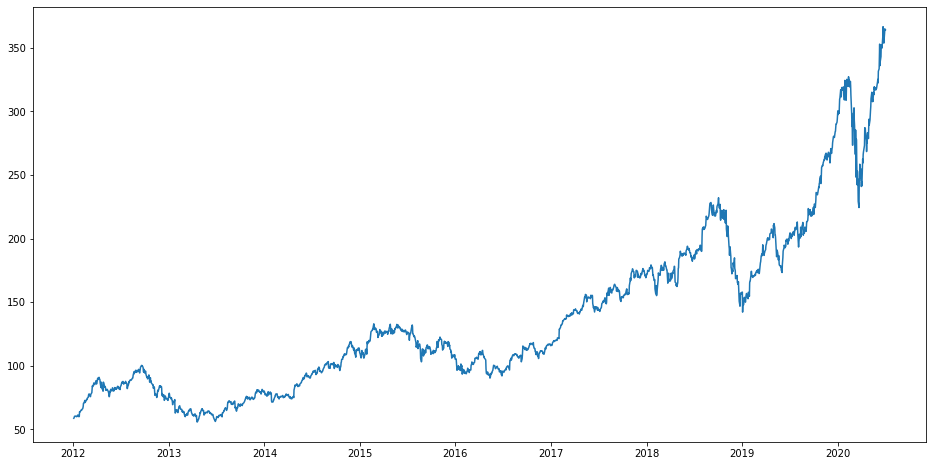

In [5]:
plt.figure(figsize=(16,8))

plt.plot(df.index, df['Close']);

In [6]:
df = df.filter(['Date', 'Close'])

In [7]:
df.head()

,Close
Date,
2012-01-03,58.747143
2012-01-04,59.062859
2012-01-05,59.718571
2012-01-06,60.342857
2012-01-09,60.247143


In [8]:
train_size = int(len(df) * 0.85)
test_size = len(df) - train_size

train, test = df.iloc[:train_size], df.iloc[train_size:]
print(train.shape, test.shape)

(1818, 1) (321, 1)


In [9]:
scaler = MinMaxScaler(feature_range=(0, 1)) 
train['Close'] = scaler.fit_transform(train[['Close']])
test['Close'] = scaler.fit_transform(test[['Close']])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
train.tail()

,Close
Date,
2019-03-20,0.750908
2019-03-21,0.790220
2019-03-22,0.767302
2019-03-25,0.754198
2019-03-26,0.743136


In [11]:
def create_dataset(X, y, time_steps):
    Xs, Ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i: (i + time_steps)].values
        Xs.append(v)
        Ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(Ys)

In [12]:
TIME_STEPS = 60
X_train, y_train = create_dataset(train[['Close']], train.Close, TIME_STEPS)
X_test, y_test = create_dataset(test[['Close']], test.Close, TIME_STEPS)

print(X_train.shape)

(1758, 60, 1)


In [13]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape= (X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [14]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/10
50/50 [==============================] - 2s 48ms/step - loss: 0.0067 - val_loss: 0.0095
Epoch 2/10
50/50 [==============================] - 2s 38ms/step - loss: 0.0090 - val_loss: 0.0080
Epoch 3/10
50/50 [==============================] - 2s 37ms/step - loss: 0.0100 - val_loss: 0.0055
Epoch 4/10
50/50 [==============================] - 2s 37ms/step - loss: 0.0058 - val_loss: 0.0036
Epoch 5/10
50/50 [==============================] - 2s 38ms/step - loss: 0.0016 - val_loss: 0.0022
Epoch 6/10
50/50 [==============================] - 2s 38ms/step - loss: 5.3205e-04 - val_loss: 0.0024
Epoch 7/10
50/50 [==============================] - 2s 37ms/step - loss: 6.3843e-04 - val_loss: 0.0023
Epoch 8/10
50/50 [==============================] - 2s 38ms/step - loss: 7.4950e-04 - val_loss: 0.0024
Epoch 9/10
50/50 [==============================] - 2s 37ms/step - loss: 9.7092e-04 - val_loss: 0.0025
Epoch 10/10
50/50 [==============================] - 2s 37ms/step - loss: 0.0013 - val_loss: 

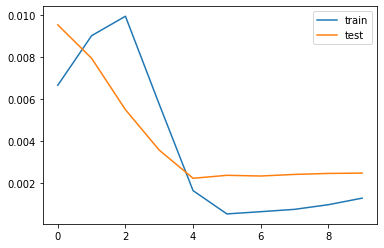

In [15]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [34]:
y_pred = model.predict(X_test)
y_train_inv = scaler.inverse_transform(y_train.reshape(1, -1))
y_test_inv = scaler.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = scaler.inverse_transform(y_pred)

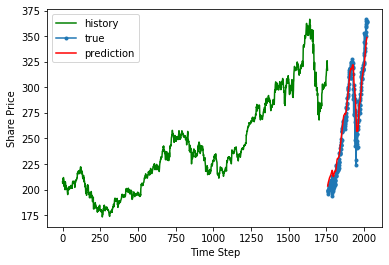

In [35]:
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Share Price')
plt.xlabel('Time Step')
plt.legend()
plt.show();

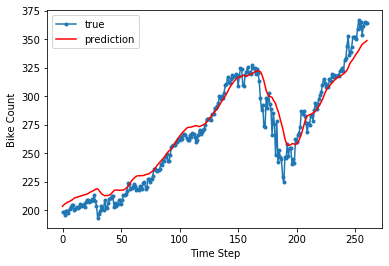

In [36]:
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Share Price')
plt.xlabel('Time Step')
plt.legend()
plt.show();